<a href="https://colab.research.google.com/github/Nikhil-Nandam/TensorFlow-Notebooks/blob/main/04_Transfer_Learning_in_TensorFlow_Part_1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are 2 main benefits:
1. Can leverage an exisiting neural network's architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Tue May 17 11:45:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-05-17 11:45:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.74.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   213MB/s    in 0.8s    

2022-05-17 11:45:31 (213 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10% data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)}, directories and {len(filenames)} in {dirpath}")

There are 2, directories and 0 in 10_food_classes_10_percent
There are 10, directories and 0 in 10_food_classes_10_percent/train
There are 0, directories and 75 in 10_food_classes_10_percent/train/ramen
There are 0, directories and 75 in 10_food_classes_10_percent/train/hamburger
There are 0, directories and 75 in 10_food_classes_10_percent/train/steak
There are 0, directories and 75 in 10_food_classes_10_percent/train/sushi
There are 0, directories and 75 in 10_food_classes_10_percent/train/grilled_salmon
There are 0, directories and 75 in 10_food_classes_10_percent/train/ice_cream
There are 0, directories and 75 in 10_food_classes_10_percent/train/pizza
There are 0, directories and 75 in 10_food_classes_10_percent/train/fried_rice
There are 0, directories and 75 in 10_food_classes_10_percent/train/chicken_curry
There are 0, directories and 75 in 10_food_classes_10_percent/train/chicken_wings
There are 10, directories and 0 in 10_food_classes_10_percent/test
There are 0, directories a

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                  target_size=IMAGE_SHAPE,
                                  batch_size=BATCH_SIZE,
                                  class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: [TensorFlow Hub](https://tfhub.dev/)

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
[Feature Vector Model](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub featire extraction URL.
        num_classes (int): Number of outpuut neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE + (3, ))   # freeze the already learnt patterns

    # Create our own model
    model1 = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model1

### Creating and Testing ResNet TensorFlow Hub Feature Extraction Model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Let's fit our ResNet model to the data (10% of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(
                                      dir_name="tensorflow_hub",
                                      experiment_name="resnet50V2"
                                  )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220517-114552
Epoch 1/5
24/24 [==============================] - 50s 1s/step - loss: 1.9752 - accuracy: 0.3253 - val_loss: 1.2631 - val_accuracy: 0.5948
Epoch 2/5
24/24 [==============================] - 22s 951ms/step - loss: 0.9500 - accuracy: 0.7227 - val_loss: 0.8735 - val_accuracy: 0.7208
Epoch 3/5
24/24 [==============================] - 23s 982ms/step - loss: 0.6399 - accuracy: 0.8173 - val_loss: 0.7627 - val_accuracy: 0.7472
Epoch 4/5
24/24 [==============================] - 23s 977ms/step - loss: 0.4988 - accuracy: 0.8640 - val_loss: 0.7249 - val_accuracy: 0.7628
Epoch 5/5
24/24 [==============================] - 22s 937ms/step - loss: 0.3934 - accuracy: 0.9053 - val_loss: 0.6844 - val_accuracy: 0.7788


Wow!

That. Is. Incredible! Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% 

In [13]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...

import matplotlib.pyplot as plt
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow History object.

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))    # how many epochs did we run for?

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

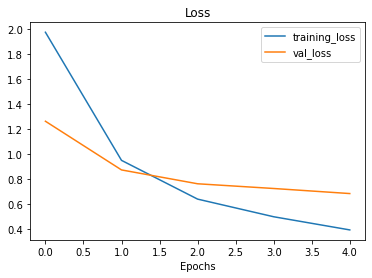

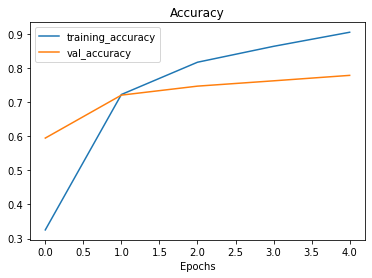

In [14]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [15]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit the EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220517-115602
Epoch 1/5
24/24 [==============================] - 35s 970ms/step - loss: 1.8144 - accuracy: 0.4267 - val_loss: 1.2796 - val_accuracy: 0.7472
Epoch 2/5
24/24 [==============================] - 20s 857ms/step - loss: 1.0401 - accuracy: 0.7827 - val_loss: 0.8450 - val_accuracy: 0.8256
Epoch 3/5
24/24 [==============================] - 20s 852ms/step - loss: 0.7377 - accuracy: 0.8507 - val_loss: 0.6845 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 20s 852ms/step - loss: 0.5937 - accuracy: 0.8760 - val_loss: 0.6027 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 20s 853ms/step - loss: 0.5063 - accuracy: 0.8947 - val_loss: 0.5523 - val_accuracy: 0.8632


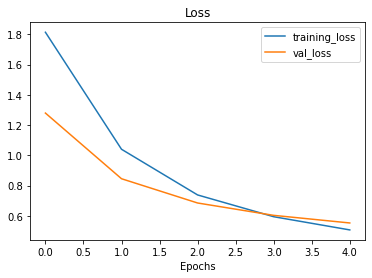

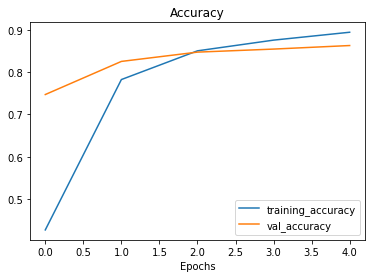

In [16]:
plot_loss_curves(efficientnet_history)

In [17]:
 efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [20]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)